# Считывание и отбор данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [103]:
DELETE_WOREF = True # удалять ли из датасета записи с отсутствующими некстраполируемыми референсами
DELETE_MULREF = True # удалять ли из датасета записи с отсутствующими экстраполируемыми множественными референсами
DELETE_ZERO_RANGES = False # удалять ли записи с диапазонами [0, 0]
INCLUDE_GAS_INTO_HEMA = False # объединять ли item category 'Blood Gas' и 'Hematology'

In [4]:
def naprop(x):
    return x.isna().sum() / x.shape[0] * 100

In [21]:
while not os.getcwd().endswith('labevent'):
    os.chdir('..')
os.getcwd()

'C:\\Users\\user\\labevent'

In [176]:
import missingno

ModuleNotFoundError: No module named 'missingno'

## labevents

In [22]:
labev = pd.read_csv('data/2.2/labevents.csv.gz')

In [23]:
labev.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,172061,10014354,29600294.0,1808066,51277,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,15.4,15.40,%,10.5,15.5,NaN,ROUTINE,NaN
1,172062,10014354,29600294.0,1808066,51279,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,3.35,3.35,m/uL,4.6,6.1,abnormal,ROUTINE,NaN
2,172068,10014354,29600294.0,1808066,52172,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,49.7,49.70,fL,35.1,46.3,abnormal,ROUTINE,NaN
3,172063,10014354,29600294.0,1808066,51301,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,20.3,20.30,K/uL,4.0,10.0,abnormal,ROUTINE,NaN
4,172050,10014354,29600294.0,1808066,51249,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,31.1,31.10,g/dL,32.0,37.0,abnormal,ROUTINE,NaN


**labevent_id** - численный идентификатор 

**patient_id** - идентификатор пациента (как узнать характеристики пациента?)

**hadm_id** - лаборатории, близкие к больничным *stay* ???

**specimen_id** - образец, на котором сделаны измерения (может применяться для группировки разных 
измерений на одном образце) \[аналог реагента\] 

**itemid** - тип образца (1622 типа)

**order_provider_id** - кто заказал исследование (не важно)

**charttime** / **storetime** - время регистрации и получения результатов (можно использовать для оценки старости образца, но малоинформативно)

**value, valuenum** - значение как object и значение numeric

**valueuom** - мера измерения

**ref_range_lower, ref_range_upper** - референсные значения

**flag** - метка нормальности (входит ли в референс)

**priority** - в каком режиме проведено исследование (теоретически, может иметь влияние на характеристики)

Проверим количество пропусков в столбцах (%)

In [104]:
labev.drop(['labevent_id', 'hadm_id', 'priority', 'flag', 'comments', 'storetime', 'charttime', 'order_provider_id'], axis=1, inplace=True)

In [105]:
naprop(labev)

subject_id          0.000000
specimen_id         0.000000
itemid              0.000000
value               8.900276
valuenum           11.585768
valueuom           15.040798
ref_range_lower    17.384685
ref_range_upper    17.384685
dtype: float64

### Обработка единиц измерения

Проверим, выполняется ли для одного itemid единообразие представленных данных

In [106]:
tmp = labev[['itemid', 'valueuom']]
res = tmp.groupby('itemid').aggregate('nunique')
res.value_counts()

valueuom
1           295
0           199
2             4
dtype: int64

4 типа тестирования показывают неоднозначность в указании единиц измерения

In [107]:
itemids = res[res.valueuom == 2].index.tolist() # неоднозначные itemid
p = labev.itemid.isin(itemids).astype(int).sum()
print(f'Набор itemids соответствует {p} записей, что составляет {p / labev.shape[0] * 100 :.2f} %')

Набор itemids соответствует 2789 записей, что составляет 2.59 %


Поскольку количество подобных записей невелико, удалим их из датасета, 
а также уберём колонку *valueuom* за неинформативностью 

In [108]:
labev.drop(['valueuom', 'value'], axis=1, inplace=True)
labev = labev[~ labev.itemid.isin(itemids)]

In [109]:
naprop(labev)

subject_id          0.000000
specimen_id         0.000000
itemid              0.000000
valuenum           11.880348
ref_range_lower    17.846729
ref_range_upper    17.846729
dtype: float64

Удалим те записи, для которых неизвестны значения испытаний *valuenum*

In [110]:
labev = labev[~ labev.valuenum.isna()]
naprop(labev)

subject_id         0.000000
specimen_id        0.000000
itemid             0.000000
valuenum           0.000000
ref_range_lower    7.938705
ref_range_upper    7.938705
dtype: float64

### Обработка значений с неизвестными референсами 

In [111]:
len(set(labev.ref_range_lower.isna().index) ^ set(labev.ref_range_upper.isna().index ))

0

нулевая симметричная разность индексов говорит, что нет таких записей, в которых не указан только один из пределов

In [112]:
idx = labev[labev.ref_range_lower.isna()].index
itemids = labev.loc[idx, 'itemid'].unique() # индекс экспериментов, в которых отсутствуют референсы

In [113]:
idx = labev[~labev.ref_range_lower.isna()].index
other = labev.loc[idx, 'itemid'].unique() # индекс экспериментов, в которых присутствуют референсы

In [114]:
inter = np.intersect1d(itemids, other) # индекс экспериментов, в которых возможна экстраполяция
woref = np.setdiff1d(itemids, other) # записи без референсов без подобных экспериментов

#### Экстраполируемые
Проверим, как много записей демонстрируют неоднозначность в референсных значениях

In [115]:
tmp = labev[(labev.itemid.isin(inter))]\
.groupby('itemid')\
.agg({'ref_range_upper': ['nunique', 'max'], 'ref_range_lower': ['nunique', 'min'], 
      'subject_id': 'count',})
# .rename(columns={'ref_range_lower': 'nunique', 'ref_range_upper': 'max', 'subject_id': 'count', 'ref_range_lower': 'min'})
# tmp[~tmp.ref_range_lower.isin((0, 1))].ref_range_upper.sum() / labev.shape[0] * 100
tmp

ref_range_upper        ref_range_lower       subject_id
               nunique    max         nunique   min      count
itemid                                                        
50904                1  999.0               1  41.0         59
50934                1   40.0               1   0.0       1300
50947                1   10.0               1   0.0       1300
51478                1    0.0               1   0.0         68
51484                1    0.0               1   0.0         47
51492                1    0.0               1   0.0        175
51678                1   60.0               1   0.0       1300
52135                1    0.6               1   0.0        226
52286                1    5.0               1   0.0          8

Среди тех записей, в которых возможна экстраполяция референсов, существует 59 записей (*itemid == 50904*), для которых существует более одной пары референсных значений. Следовательно, можно удалить записи с *itemid == 50904*, и беспрепятственно экстраполировать референсы для остальных.

Также существуют пустые диапазоны \[0., 0.\], которые, по-видимому, следует исключить из рассмотрения.

In [116]:
lowers = tmp[tmp[('ref_range_lower', 'nunique')] == 1][('ref_range_lower', 'min')]
uppers = tmp[tmp[('ref_range_upper', 'nunique')] == 1][('ref_range_upper', 'max')]

In [117]:
def fillna_map(x, col, mapping, ax_col, inplace=True):
    if not inplace:
        x = x.copy()
    idx = x[x[col].isna()].index
    x.loc[idx, col] = x.loc[idx, ax_col].map(mapping)
    return x

_ = fillna_map(labev, 'ref_range_lower', lowers, 'itemid')
_ = fillna_map(labev, 'ref_range_upper', uppers, 'itemid')

In [118]:
if DELETE_MULREF:
    labev.drop(tmp[tmp[('ref_range_lower', 'nunique')]  > 1].index, inplace=True)

In [119]:
if DELETE_ZERO_RANGES:
    labev = labev[labev.ref_range_upper != labev.ref_range_lower]

#### Неэкстраполируемые

In [120]:
tmp = labev[labev.itemid.isin(woref)]
print(f'Доля неэкстраполируемых записей: {tmp.shape[0] / labev.shape[0] * 100: .2f}%')
# .fillna(0)\
# .groupby('itemid')\
# .agg({'ref_range_upper': 'count'})
# # tmp[~tmp.ref_range_lower.isin((0, 1))].ref_range_upper.sum() / labev.shape[0] * 100
# tmp.sum()

Доля неэкстраполируемых записей:  3.28%


Поскольку количество значений, для которых нет образцов в датасете, невелико, можем удалить их, поскольку их заполнение потребует более тщательного анализа *itemid*

In [121]:
if DELETE_WOREF:
    labev.drop(tmp.index, inplace=True)
    
path = 'data/refined/labevents.csv'
if not os.path.exists(path):
    labev.to_csv(path)

## Patients

Рассмотрим значения, характеризующие пациентов

In [122]:
labadm = pd.read_csv('data/2.2/admissions.csv.gz',
                     usecols=['subject_id', 'language', 'marital_status', 'race'], index_col='subject_id')
labpat = pd.read_csv('data/2.2/patients.csv.gz',
                     usecols=['subject_id', 'gender', 'anchor_age',], index_col='subject_id')

In [123]:
labpat = labpat.join(labadm, how='left')
labpat.replace('?', np.nan, inplace=True)

In [124]:
labpat.drop_duplicates(inplace=True)

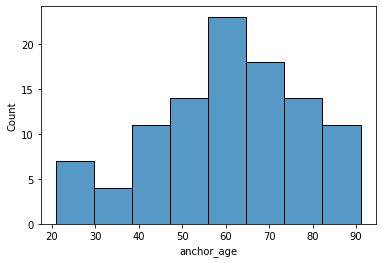

In [125]:
_ = sns.histplot(labpat.anchor_age)

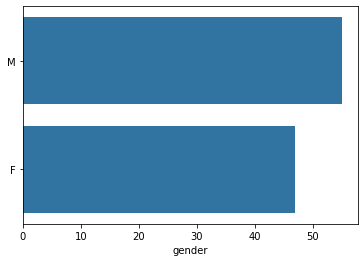

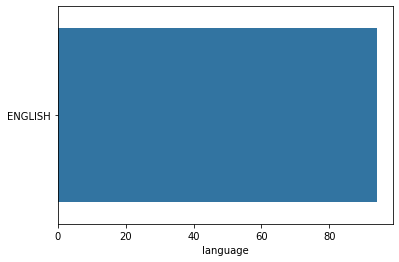

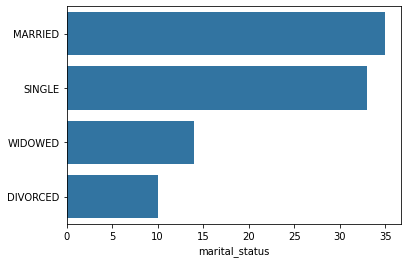

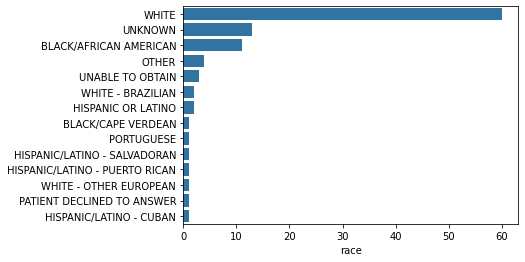

In [126]:
def plot_cat(X):
    for col, type_ in X.dtypes.items():
        if type_ != 'object':
            continue
        sns.barplot(X[col].value_counts(), orient='h')
        plt.show()
plot_cat(labpat)

Можно увидеть, что признак language можно исключить, также объединить race в более большие группы

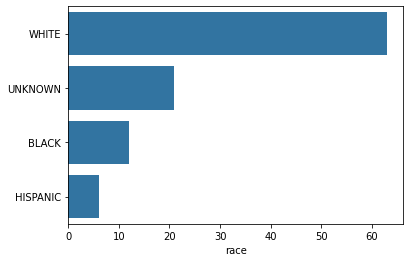

In [127]:
def race_transform(x):
    if 'WHITE' in x:
        return 'WHITE'
    elif 'HISPANIC' in x or 'PORTUGUESE' in x:
        return 'HISPANIC'
    elif 'BLACK' in x:
        return 'BLACK'
    else:
        return 'UNKNOWN'
    
_ = sns.barplot(labpat.race.map(race_transform).value_counts(), orient='h')

In [128]:
if 'language' in labpat.columns:
    labpat.drop('language', axis=1, inplace=True)
    
labpat.loc[:, 'race'] = labpat.race.map(race_transform)
labpat.rename(columns={'anchor_age': 'age'}, inplace=True)

In [129]:
naprop(labpat)

gender            0.000000
age               0.000000
marital_status    9.803922
race              0.000000
dtype: float64

9.8% пациентов соответствует 2805 записям (~3% labev) 

In [130]:
labev[labev.subject_id.isin(labpat[labpat.marital_status.isna()].index)].shape[0]

2339

Не удалось заполнить пропуски в *marital_status* на основании байесовского классификатора

In [131]:
labpat.drop('marital_status', axis=1, inplace=True)

In [132]:
# from sklearn.naive_bayes import CategoricalNB
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import classification_report
# from sklearn.ensemble import BaggingClassifier

# na = labpat.marital_status.isna()

# tmp = labpat[~na]
# cats = [np.sort(labpat[x].unique()) for x in labpat.columns if x != 'marital_status']
# ordtr = OrdinalEncoder(categories=cats,).fit(labpat.drop('marital_status', axis=1))
# X = ordtr.transform(tmp.drop('marital_status', axis=1))
# y = tmp['marital_status']                                          

# xtr, xte, ytr, yte = train_test_split(X, y, random_state=2100)
# imp = BaggingClassifier(CategoricalNB(alpha=.1), 50)
# grid = {
#     'base_estimator__alpha': [1e-10, 1e-6, 1e-4, 1e-3, .01, .1, 1, 10, 100, 1e3, 1e6] 
# }
# gs = GridSearchCV(imp, param_grid=grid, cv=5, scoring='accuracy').fit(xtr, ytr,)
# imputer = gs.best_estimator_
# print(classification_report(yte, imputer.predict(xte)))


In [133]:
# topred = labpat[na].drop('marital_status', axis=1)
# pred = pd.Series(imputer.predict(ordtr.transform(topred)), index=topred.index)
# labpat.loc[na[na].index, 'marital_status'] = pred.loc[na[na].index] 

In [134]:
path = 'data/refined/patients.csv'
if not os.path.exists(path):
    labpat.to_csv(path)

## Items



In [135]:
labit = pd.read_csv('data/2.2/d_labitems.csv.gz', index_col='itemid')

In [136]:
labit.label.value_counts().sort_values().tail(10)

Fl Scan             6
Myelocytes          6
NRBC                7
Clostrid            7
Eosinophils         7
Beta                8
Alpha-2             8
Alpha-1             8
Voided Specimen    20
Delete             32
Name: label, dtype: int64

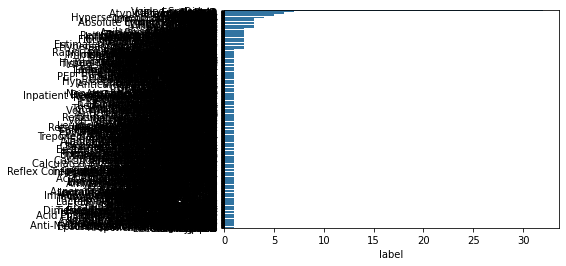

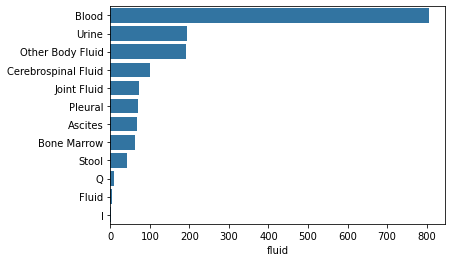

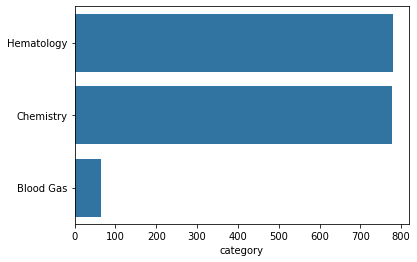

In [137]:
plot_cat(labit) # оставлю тут, как иллюстрацию всей тяжести полезной графы label...
#(хотя может есть смысл это кодировать через какие-нибудь NLP эмбеддинги)

* Признак *category* выглядит излишним по причине перекрытия с матриалом по крови
* *fluid: Q, Fluid, I* следует удалить в силу малого вхождения, либо включить в *fluid == Blood*
* Без NLP эмбеддингов имеет смысл выкинуть названия *label*

In [138]:
if 'label' in labit.columns:
    labit.drop('label', inplace=True, axis=1)

torep = labit.fluid.isin(('Q', 'Fluid', 'I'))
labit[torep]

,fluid,category
itemid,,
52039,Fluid,Blood Gas
52042,Fluid,Blood Gas
52040,Fluid,Blood Gas
52038,Fluid,Blood Gas
52041,Fluid,Blood Gas
52290,I,Hematology
52398,Q,Hematology
52397,Q,Hematology
52401,Q,Hematology


In [139]:
labit.loc[torep, 'fluid'] = 'Blood'

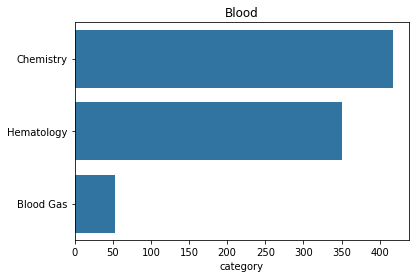

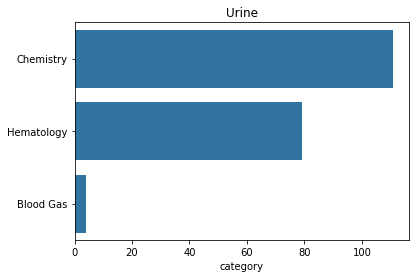

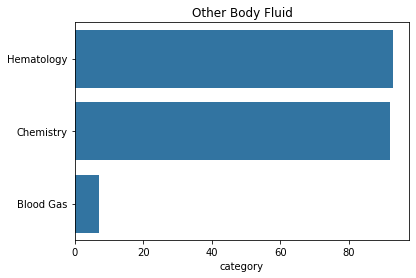

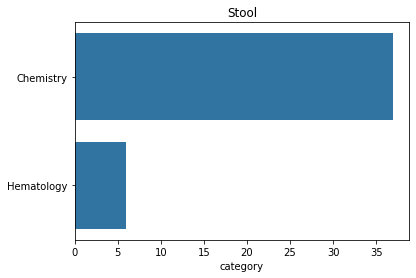

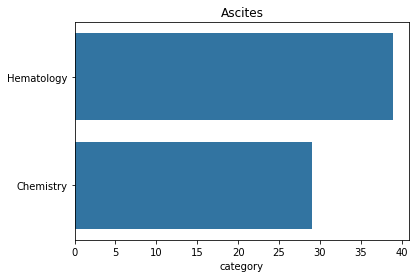

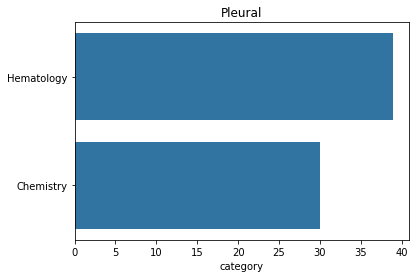

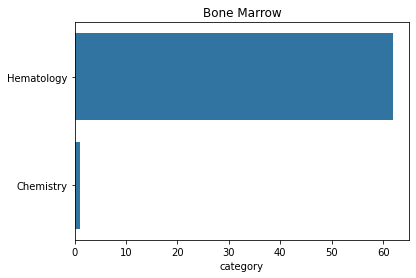

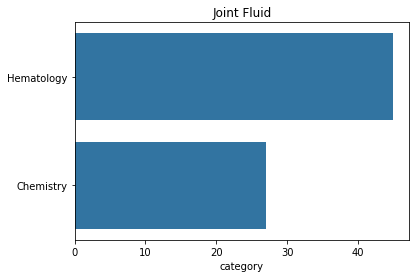

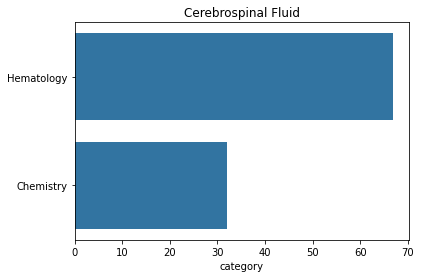

In [140]:
tmp = labit.groupby('fluid')
for fluid in labit.fluid.unique():
    sns.barplot(tmp.get_group(fluid).category.value_counts(), orient='h')
    plt.title(fluid)
    plt.show()

Всё-таки можно увидеть, что распределения жидкостей по различным анализам практически без пустующих столбцов (хотя меня несколько смущает количество анализов спинномозговой жидкости, например, на гематологию...)

Но можно объединить *blood gas* и *hematology*

In [141]:
if INCLUDE_GAS_INTO_HEMA:
    labit.loc[:, 'category'] = labit.category.map(lambda x: x if x != 'Blood Gas' else 'Hematology')

In [142]:
path = 'data/refined/tests.csv'
if not os.path.exists(path):
    labit.to_csv(path)

# Объединение

In [143]:
ev = labev.join(labpat, on='subject_id', how='left')
ev = ev.join(labit, on='itemid', how='left')
naprop(ev)

subject_id         0.000000
specimen_id        0.000000
itemid             0.000000
valuenum           0.000000
ref_range_lower    0.000000
ref_range_upper    0.000000
gender             1.783242
age                1.783242
race               1.783242
fluid              0.000000
category           0.000000
dtype: float64

In [144]:
ev.dropna(inplace=True)
ev.drop_duplicates(inplace=True)
ev.rename(columns={'itemid': 'item_id'}, inplace=True)
ev.shape

(96452, 11)

In [145]:
ind_cols = ['subject_id', 'specimen_id', 'item_id']
index = ev[ind_cols]
index.to_csv('data/refined/index.csv')
ev.drop(ind_cols, axis=1, inplace=True)
ev.to_csv('data/refined/general.csv')

In [146]:
ev.head()

,valuenum,ref_range_lower,ref_range_upper,gender,age,race,fluid,category
0,15.40,10.5,15.5,M,60.0,WHITE,Blood,Hematology
1,3.35,4.6,6.1,M,60.0,WHITE,Blood,Hematology
2,49.70,35.1,46.3,M,60.0,WHITE,Blood,Hematology
3,20.30,4.0,10.0,M,60.0,WHITE,Blood,Hematology
5,29.60,40.0,51.0,M,60.0,WHITE,Blood,Hematology


Без привлечения дополнительных источников ценность представляют следующие данные, относящиеся к трём сущностям:

* *event: valuenum,  ref_range_lower, ref_range_upper*
* *patient: gender, age, race*
* *test: fluid, category*

Такое количество признаков можно назвать скудным. Более того, признаковые описания *test* и *patient* являются в основе своей категориальными и при One-Hot кодировании - разреженными. Оценим количество полученных комбинаций признаков

In [147]:
#количества уникальных пацентов, взятых образцов и исследований
uni = index.nunique()
uni

subject_id       92
specimen_id    9793
item_id         213
dtype: int64

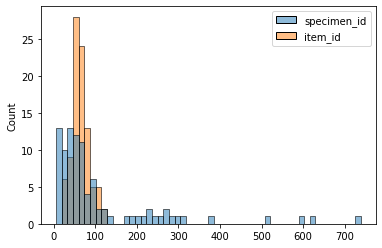

,min,mean,median,max
specimen_id,6.000000,106.445652,58.500000,738.000000
item_id,29.000000,64.054348,62.000000,123.000000
spec./item,0.157895,1.356802,0.930847,6.648649


In [148]:
tmp = index.groupby('subject_id').agg({'specimen_id': 'nunique', 'item_id': 'nunique'})
_ = sns.histplot(tmp)
plt.show()
tmp['spec./item'] = tmp.specimen_id / tmp.item_id
pd.DataFrame({stat: getattr(tmp, stat)(axis=0) for stat in ['min', 'mean', 'median', 'max',]}) 

Наиболее часто пациенты сдавали около 60.5 различных образцов, каждый из которых использовался примерно для одного анализа. Тем не менее, можно заметить, что некотоорые пациенты требовали более тщательного обследования, что выражается в высоких значениях *specimen_id/item_id max*. Значение *spec./item* 0.17 говорит о том, что минимум на один образец приходилось 6 анализов

In [149]:
cols = ['gender', 'age', 'race', 'fluid', 'category']
ev[cols].nunique()

gender       2
age         50
race         4
fluid        7
category     3
dtype: int64

In [150]:
tmp = ev[['age', 'gender', 'race',]].drop_duplicates()
print(f'Количество уникальных сочетаний характеристик {tmp.shape[0]} на {uni["subject_id"]} пациентов')

tmp = ev[['gender', 'race',]].drop_duplicates()
print(f'Без учёта возраста количество уникальных сочетаний характеристик {tmp.shape[0]} на {uni["subject_id"]} пациентов')

Количество уникальных сочетаний характеристик 86 на 92 пациентов
Без учёта возраста количество уникальных сочетаний характеристик 8 на 92 пациентов


In [151]:
tmp = ev[['fluid', 'category',]].drop_duplicates()
print(f'Количество уникальных сочетаний {tmp.shape[0]} из {uni["item_id"]} типов анализов')
tmp

Количество уникальных сочетаний 11 из 213 типов анализов


,fluid,category
0,Blood,Hematology
11,Blood,Chemistry
449,Urine,Hematology
954,Ascites,Hematology
1056,Blood,Blood Gas
2027,Urine,Chemistry
13044,Other Body Fluid,Hematology
14032,Joint Fluid,Hematology
39674,Pleural,Hematology
47477,Cerebrospinal Fluid,Chemistry


# Вопросы на подумать

* Для сравнения полученных методов лучше пока что использовать задачу регрессии по *valuenum*? Или нужно сразу  придумать более похожие на изначальные условия: добавить таргет *normality = all(valuenum in reference)* для пациента и предсказывать его по набору *valuenum*, проведённых для пациента? 
* В каком порядке стоит изучать построения графов: гомогенный, пациент - анализ, пациент - анализ - тест?
* Стоит ли делать введение дополнительные признаки на основании названия теста и NLP?
* Стоит ли учитывать референсные границы и к чему их относить: к признакам теста или конкретного анализа? (учитывая, например, половые физиологические различия)?
* Как обращаться с категориальными признаками (без отношения порядка)? OHE генерирует очень разреженную матрицу, следовательно, нужны эмбеддинги, но тогда пропущенные значения, некоторым образом заполненные, влияют на всё векторное представление. 
* Можно ли как-то разделить обработку по признакам? Или добавить бинарные индикаторы, что такая-то величина была пропущена?
* Методы кодирования категориальных переменных для рассмотрения ещё: frequency encoding, mean encoding (если, например, не выделять отдельно узлы с исключительно дискретными описаними), probability-ratio (если использовать *normality*) и прочие target-based техники (проблема data leakage)


# Отбор

In [168]:
ev = pd.read_csv('data/refined/general.csv', index_col=0)
index_df = pd.read_csv('data/refined/index.csv', index_col=0)

#choose appropiate fluid scope
selected = { 
    'fluid': ['Blood'],
    # 'category': ['Hemotology', 'Chemistry', 'Blood Gas'],
    'category': ['Chemistry'],
}

def select_categories(events, index_df, selected, ind_cols, set_index=True):
    ev = events.copy()
    mask = pd.Series(np.ones((ev.shape[0],)) == 1, index=ev.index)
    for col in selected:
        mask &= ev[col].isin(selected[col])
    ev = ev[mask]
    cuniq = ev.nunique() == 1
    res = ev.join(index_df.loc[mask, ind_cols])
    res.drop_duplicates(inplace=True)
    res.drop(cuniq[cuniq].index.tolist(), axis=1, inplace=True)
    if set_index:
        res.set_index(ind_cols)
    return res

In [169]:
sev = select_categories(ev, index_df, selected, ['subject_id', 'specimen_id'], False)

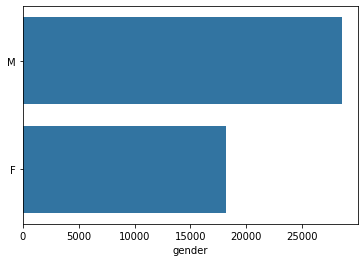

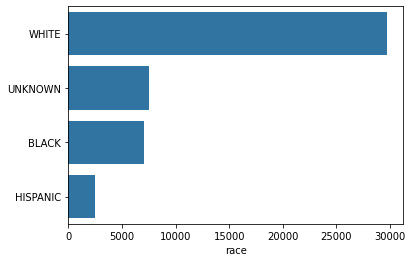

In [170]:
plot_cat(sev.drop(['subject_id', 'specimen_id'], axis=1).select_dtypes(include=['int64', 'object']))

In [171]:
sevvar = select_categories(ev, index_df,
                           { 
    'fluid': ['Blood'],
    'category': ['Hematology', 'Chemistry', 'Blood Gas'],
    # 'category': ['Chemistry'],
}, 
                           ['subject_id', 'specimen_id'], False)

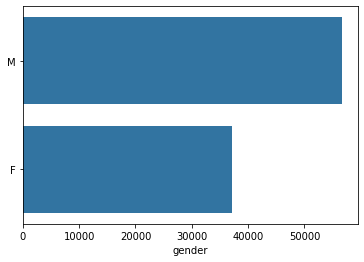

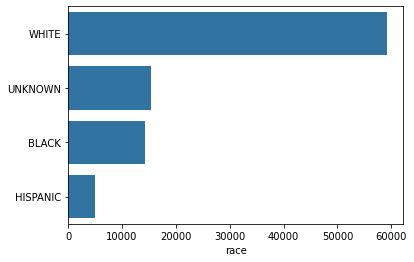

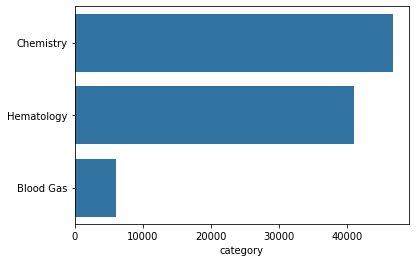

In [172]:
plot_cat(sevvar.drop(['subject_id', 'specimen_id'], axis=1).select_dtypes(include=['int64', 'object']))

(93757, 9)